# Wind ANN 

### Load and preprocess data

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_2Day'] = data['BeginDate'] - pd.Timedelta(days=2)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
wind_data = data[['BeginDate', 'Wind','Previous_Day','Previous_Year','Previous_2Day']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_56408\299724603.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')


In [8]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Wind'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [9]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Wind'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [10]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Wind'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [11]:
# Large computation 
data['Previous_Year_Wind'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)

In [12]:
cutoff_date = pd.to_datetime("2023-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Wind','Previous_Day','Previous_2Day','Previous_Year']].copy()

In [13]:


usable_data['Previous_Day_Wind'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Wind'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=solar_data2)


In [14]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Month'] = usable_data['BeginDate'].dt.month
usable_data['Year'] = usable_data['BeginDate'].dt.year
features = usable_data[['Month','Year','Previous_Year_Wind','Previous_2Day_Wind','Sum','snowdepth','temp','solarenergy','sealevelpressure', 'humidity','solarenergy','snow', 'precip', 'uvindex', 'cloudcover', 'Previous_Day_Wind','Hour_of_Day','dew','windgust','windspeed','winddir']]

# Useless Features , ,
target = usable_data['Wind']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (93643, 21)
Target shape:  (93643,)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=700, validation_split=0.15, batch_size=32)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/500


C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1990/1990 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 196.0240 - val_loss: 148.2478
Epoch 2/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 148.4822 - val_loss: 142.8413
Epoch 3/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - loss: 144.3443 - val_loss: 137.8099
Epoch 4/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - loss: 141.9117 - val_loss: 134.0540
Epoch 5/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - loss: 138.4266 - val_loss: 133.6870
Epoch 6/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 136.1646 - val_loss: 128.0574
Epoch 7/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - loss: 134.8837 - val_loss: 125.4865
Epoch 8/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - loss: 133.1622 - val_loss: 124.2460
Epoch 9/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - loss: 131.2669 - val_loss: 120.9932
Epoch 10/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - loss: 128.9363 - val_loss: 118.7857
Epoch 11/500
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - loss

KeyboardInterrupt: 

### Analysis

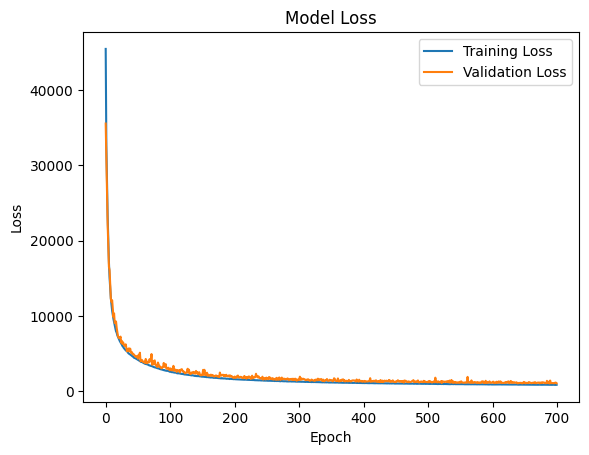

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [ ]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted Solar Energy Ouput: [1002.5513305664062, 46.98427963256836, 464.2265319824219, 102.72356414794922, 95.91348266601562, 980.8984985351562, 838.8299560546875, 465.2689514160156, 400.0727844238281, 398.5088806152344, 629.7739868164062, 184.55877685546875, 659.1001586914062, 211.14390563964844, 279.7440490722656, 341.7652893066406, 117.65876007080078, 76.1279296875, 258.7194519042969, 45.20821762084961]
Actual Solar Energy Output: [1033.   51.  448.  104.   96.  983.  792.  420.  445.  382.  605.  171.
  655.  167.  289.  325.  108.   89.  237.   34.]


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 24.259763524411255
Mean Squared Error (MSE): 1024.8424252624964
Root Mean Squared Error (RMSE): 32.013160188623935
Percent Error (PERR): 0.06501779285319724


### Save model

In [ ]:
model.save('WindModel.h5')